# Imports

In [1]:
import pickle
import os
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt
import librosa
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tqdm import tqdm
import torch.optim as optim
import torchvision.transforms.functional as F

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Pickle Files

load the pickle files, audio_data is a list of arrays, where the arrays are of different shapes

In [2]:
def trim_array(arr):
    if np.all(arr == 0):  # Check if the array is all zeros
        return arr
    first_non_zero = np.argmax(arr != 0)
    last_non_zero = len(arr) - np.argmax(arr[::-1] != 0)
    return arr[first_non_zero:last_non_zero]

In [3]:
allaudios = [] # Creates an empty list
for root, dirs, files in os.walk("train"):
    i=0 
    for file in files:
        if file.endswith(".pkl"):
           audio = file
           openaudios = open(os.getcwd() + "/train/" + audio, 'rb')
           loadedaudios = pickle.load(openaudios)
           
           allaudios.append(loadedaudios)
           i+=1
        #    if i==1000:
        #        break

audio_data = []
valence = []
audio_lengths = []
for audio in allaudios:
    # Get Rid of front and end trailing zeros
    audio_trimmed = trim_array(audio['audio_data'])
    audio_data.append(audio_trimmed)

    audio_length = len(audio_trimmed)
    audio_lengths.append(audio_length)
    valence.append(audio['valence'])

# Data Investigation

In [4]:
print(len(audio_data))
print(len(valence))

10557
10557


In [5]:
mean = np.mean(np.concatenate(audio_data))
mom = np.mean([np.mean(arr) for arr in audio_data]) # mean of means

std = np.std(np.concatenate(audio_data))
average_std = np.mean([np.std(arr) for arr in audio_data])

print(f'Concatenated mean: {mean} \nMean of Means:{mom} \nConcatenated std: {std} \nAverage std per array {average_std}')


Concatenated mean: -1.2947517689099186e-06 
Mean of Means:7.272608399944147e-07 
Concatenated std: 0.08257412165403366 
Average std per array 0.061843693256378174


does not max sense to go off max better to take mean or median 

Mean Length: 35231.4606422279
Median Length: 31968.0
Standard Deviation: 19788.10900767289
Minimum Length: 5998
Maximum Length: 174624


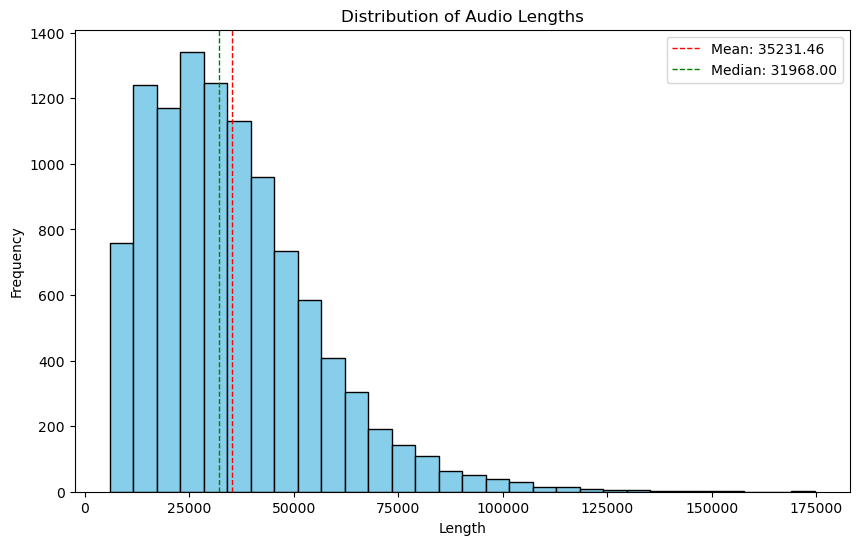

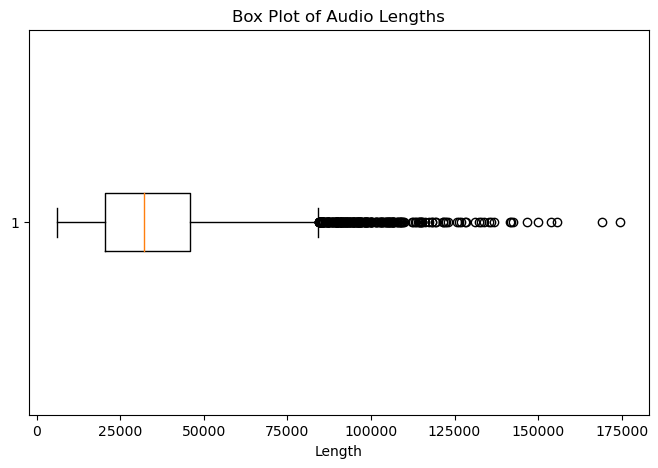

In [6]:
mean_length = np.mean(audio_lengths)
median_length = np.median(audio_lengths)
std_dev = np.std(audio_lengths)
min_length = np.min(audio_lengths)
max_length = np.max(audio_lengths)

print("Mean Length:", mean_length)
print("Median Length:", median_length)
print("Standard Deviation:", std_dev)
print("Minimum Length:", min_length)
print("Maximum Length:", max_length)

# Histogram of the lengths
plt.figure(figsize=(10, 6))
plt.hist(audio_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Audio Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.axvline(mean_length, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_length:.2f}')
plt.axvline(median_length, color='g', linestyle='dashed', linewidth=1, label=f'Median: {median_length:.2f}')
plt.legend()
plt.show()

# Optional: Box Plot
plt.figure(figsize=(8, 5))
plt.boxplot(audio_lengths, vert=False)
plt.title('Box Plot of Audio Lengths')
plt.xlabel('Length')
plt.show()

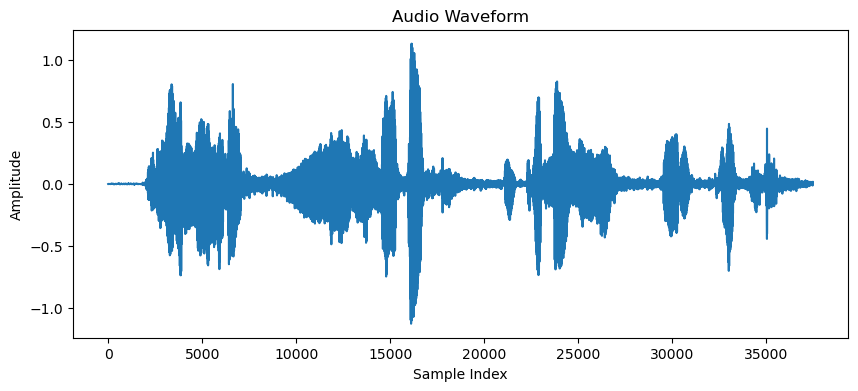

In [7]:
plt.figure(figsize=(10, 4))  # Specify the figure size
plt.plot(audio_data[10])    # Plot the audio data
plt.title('Audio Waveform')  # Set the title of the plot
plt.xlabel('Sample Index')   # Label for the x-axis
plt.ylabel('Amplitude')      # Label for the y-axis
plt.show()  

# Pad Trunc

https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5

In [8]:
def pad_trunc_audio(audio_data, target_length = int(np.percentile(audio_lengths, 95))):
    standardized_data = []
    for data in audio_data:
        if len(data) < target_length:
            padded_data = np.pad(data, (0, target_length - len(data)), 'constant', constant_values=(0, 0))
            standardized_data.append(padded_data)
        elif len(data) > target_length:
            truncated_data = data[:target_length]
            standardized_data.append(truncated_data)
        else:
            standardized_data.append(data)
    return standardized_data

standardized_audios = pad_trunc_audio(audio_data)


# Train Test Data for Model

In [9]:
class AudioDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [10]:
size_train = int(round(len(standardized_audios) * 0.8))
X_train = standardized_audios[:size_train]
X_test = standardized_audios[size_train:]
y_train = valence[:size_train]
y_test = valence[size_train:]

batch_size = 64

train_dataset = AudioDataset(X_train, y_train)
test_dataset = AudioDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True,) # you can speed up the host to device transfer by enabling pin_memory.
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True,) # you can speed up the host to device transfer by enabling pin_memory.



# Model Setup

In [11]:
class CNN1d(nn.Module):
    def __init__(self, pre_proocesses, hidden_sizes, activation_function):

        super(CNN1d, self).__init__()

        self.hidden_sizes = hidden_sizes
        self.activation_function = activation_function

        self.width = 128

        self.layers = nn.ModuleList()

        # # add preprocessing steps
        # for process in pre_proocesses:
        #     self.layers.append(process)

        for i in range(len(self.hidden_sizes)):
            self.layers.append(nn.Conv1d(1 if i ==0 else self.hidden_sizes[i-1], self.hidden_sizes[i], kernel_size=3))
            self.layers.append(nn.BatchNorm1d(self.hidden_sizes[i], eps=.00001, momentum=0.1, affine=True, track_running_stats=True))
            self.layers.append(nn.MaxPool1d(kernel_size=3))
            self.layers.append(self.activation_function())


        self.layers.append(nn.AdaptiveAvgPool1d(1))
        self.layers.append(nn.Flatten()) 
        self.layers.append(nn.Linear(in_features=self.hidden_sizes[-1], out_features=self.width))
        self.layers.append(nn.Dropout(p=0.5))
        self.layers.append(nn.Linear(in_features=self.width, out_features=1))

    def forward(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    
model_self = CNN1d([], [16, 32, 64, 128, 256], nn.ReLU).to(device)
print(model_self)

CNN1d(
  (layers): ModuleList(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Conv1d(16, 32, kernel_size=(3,), stride=(1,))
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU()
    (8): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
    (12): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
   

In [12]:
# Create the model

# increased depth of the network
n_filters = [1, 16, 16, 32, 32, 64, 64, 128, 128, 256]
classifier_width = 128
cnn_layers = []
output_size = 1

for n_in, n_out in zip(n_filters[:-1], n_filters[1:]):
    cnn_layers.append(nn.Conv1d(n_in, n_out, kernel_size=3))
    cnn_layers.append(nn.ReLU())
    cnn_layers.append(nn.MaxPool1d(kernel_size=3))

# adaptive average pooling to obtain features
cnn_layers.append(nn.AdaptiveAvgPool1d(1))
cnn_layers.append(nn.Flatten())
model = nn.Sequential(
    *cnn_layers,
    nn.Linear(n_filters[-1], classifier_width),
    nn.ReLU(),
    nn.Linear(classifier_width, classifier_width),
    nn.ReLU(),
    nn.Linear(classifier_width, output_size),
)
# No soft max as loss function expects logits

model = model.to(device)
print(model)

Sequential(
  (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,))
  (1): ReLU()
  (2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (3): Conv1d(16, 16, kernel_size=(3,), stride=(1,))
  (4): ReLU()
  (5): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (6): Conv1d(16, 32, kernel_size=(3,), stride=(1,))
  (7): ReLU()
  (8): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (9): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (10): ReLU()
  (11): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (12): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (13): ReLU()
  (14): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (15): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (16): ReLU()
  (17): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (18): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (19): ReLU()
  (20): MaxPool1d

In [13]:
criterion = nn.MSELoss()

for audio, valence in train_dataloader:
    audio = audio.unsqueeze(1)
    print(audio.shape)

    outputs = model_self(audio)
    outputs = outputs.squeeze()
    print(outputs)
    print(valence)
    break

torch.Size([64, 1, 72354])
tensor([-0.1053, -0.0799, -0.0786,  0.2258,  0.0594, -0.0975, -0.2482, -0.0538,
        -0.0241, -0.0252, -0.0688, -0.0593, -0.0217, -0.0851, -0.0235, -0.0315,
        -0.0675, -0.1344,  0.0263, -0.0122,  0.1378, -0.1368, -0.0671, -0.1259,
        -0.1038,  0.0074, -0.1313, -0.1789, -0.1066, -0.1496, -0.0920,  0.1117,
         0.0525, -0.1455, -0.0391, -0.2834, -0.0461, -0.0975, -0.0947, -0.4936,
         0.1540, -0.0067, -0.1091,  0.0432,  0.1071, -0.1164, -0.0638, -0.1134,
        -0.1413, -0.0664, -0.5318, -0.1002, -0.2063, -0.0916, -0.0923, -0.1693,
        -0.0448, -0.2014, -0.0468, -0.0066, -0.0954, -0.4354, -0.0835, -0.1126],
       grad_fn=<SqueezeBackward0>)
tensor([2.2500, 2.7500, 3.2500, 1.2500, 4.5000, 2.7500, 4.0000, 3.2500, 3.7500,
        4.0000, 3.0000, 2.7500, 3.0000, 2.7500, 2.5000, 4.2500, 3.5000, 3.0000,
        4.0000, 2.5000, 2.0000, 3.0000, 3.5000, 3.2500, 3.2500, 3.5000, 2.0000,
        2.0000, 2.7500, 3.5000, 3.5000, 3.5000, 3.5000, 3

In [14]:
def calculate_metrics(actual, predicted):

    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, predicted)
    
    return {
        "Mean Absolute Error (MAE)": mae,
        "Mean Squared Error (MSE)": mse,
        "Root Mean Squared Error (RMSE)": rmse,
        "R-squared (R^2)": r2
    }


In [15]:
def loss_plot(train_loss, validation_loss):
    epochs = range(1, len(train_loss) + 1) # start at 1 instead of 0
    # Plotting the training and validation losses
    plt.figure(figsize=(5, 5))
    plt.plot(epochs, train_loss, label='Training Loss', color='blue')
    plt.plot(epochs, validation_loss, label='Validation Loss', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [16]:
def train_model(net, optimizer, train_loader, val_loader, epochs):
    # Define the loss function
    criterion = nn.MSELoss()
    # Define the optimizer

    train_loss_lst = []
    val_loss_lst = []

    for epoch in range(epochs):
        net.train()
        running_loss = 0.0
        # Iterate over training batches
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
            for audio, valence in train_loader:
                optimizer.zero_grad()  # Reset gradients
                valence = valence.float() # was double 

                audio = audio.unsqueeze(1) # [batch, channel=1, 128,145]
                audio, valence = audio.to(device), valence.to(device)

                outputs = net(audio)
                outputs = outputs.squeeze()  # Reshape the output to match target
                loss = criterion(outputs, valence)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

                pbar.set_postfix({'loss': running_loss / (len(pbar) + 1)})  # Display average loss
                pbar.update(1)  # Update the progress bar
        train_loss = running_loss / len(train_loader)
        train_loss_lst.append(train_loss)

        # Validation
        net.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for audio, valence in val_loader:
                valence = valence.float() # was double

                audio = audio.unsqueeze(1) # [batch, channel=1, 128,145]
                audio, valence = audio.to(device), valence.to(device)
                outputs = net(audio)
                outputs = outputs.squeeze()  # Reshape the output to match target
                val_loss = criterion(outputs, valence)
                val_running_loss += val_loss.item()

        val_loss = val_running_loss / len(val_loader)
        val_loss_lst.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
    #display loss graph
    loss_plot(train_loss_lst, val_loss_lst)
    print("Training for CNN is finished.")

    return val_loss_lst

In [17]:
optimizer = optim.Adam(model_self.parameters(), lr=0.001)
val_loss_lst = train_model(model_self, optimizer, train_dataloader, test_dataloader, 10)

Epoch 1/10: 100%|██████████| 132/132 [24:15<00:00, 11.03s/batch, loss=1.01]   


Epoch 1/10, Train Loss: 1.0159, Val Loss: 0.6150


Epoch 2/10: 100%|██████████| 132/132 [15:18<00:00,  6.96s/batch, loss=0.743]


Epoch 2/10, Train Loss: 0.7485, Val Loss: 0.5778


Epoch 3/10: 100%|██████████| 132/132 [14:39<00:00,  6.66s/batch, loss=0.721]


Epoch 3/10, Train Loss: 0.7269, Val Loss: 0.7420


Epoch 4/10: 100%|██████████| 132/132 [09:57<00:00,  4.53s/batch, loss=0.688]


Epoch 4/10, Train Loss: 0.6932, Val Loss: 0.5669


Epoch 5/10: 100%|██████████| 132/132 [10:51<00:00,  4.94s/batch, loss=0.668]


Epoch 5/10, Train Loss: 0.6734, Val Loss: 0.6256


Epoch 6/10:   1%|          | 1/132 [00:06<13:27,  6.16s/batch, loss=0.00375]


KeyboardInterrupt: 

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
val_loss_lst = train_model(model, optimizer, train_dataloader, test_dataloader, 10)

# Grid Search For Hyperparameters

In [ ]:
def plot_search(results, x_str, y_str, res_str, scale=False):

    # Assuming coarse_results is a list of dictionaries with 'lr', 'hidden_size', 'val_loss', and 'accuracy'
    # Extract relevant information for the heatmap
    lr_values = [result[x_str] for result in results]
    hidden_size_values = [result[y_str] for result in results]
    val_loss_values = [result[res_str] for result in results]

    # Create a heatmap
    plt.figure(figsize=(10, 8))
    heatmap = plt.scatter(lr_values, hidden_size_values, c=val_loss_values, cmap='RdYlGn', marker='o', s=100)
    plt.colorbar(heatmap, label=res_str)
    if scale:
        plt.xscale('log')  # Use a logarithmic scale for learning rates if appropriate

    # Set labels and title
    plt.xlabel(x_str)
    plt.ylabel(y_str)
    plt.title('Hyperparameter Search')
    plt.grid(True)

    # Show the plot
    plt.show()

In [ ]:
def hyper_train_setup(hidden_sizes, learning_rate, num_epochs):
  # Create the model
    model_1d = CNN1d(pre_proocesses=[], hidden_sizes=hidden_sizes, activation_function=nn.ReLU, linear_layer1_size=500).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # optimizer = optim.SGD(params=model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)

    ## Train the model
    eval_loss = train_model(model_1d, optimizer, train_dataloader, test_dataloader, num_epochs)
    return eval_loss[-1] # last epoch loss

In [ ]:
import random 
import math

# Coarse Random Search
coarse_trials = 7
num_epochs = 15
coarse_results = []


for i in range(coarse_trials):
    
    #### COMPLETE THE CODE ####
    lr = 10**random.uniform(math.log10(0.001), math.log10(0.1))
    hidden_size = int(2**random.uniform(4, 6))
    hidden_sizes = [hidden_size]
    val_loss = hyper_train_setup(hidden_sizes, lr, num_epochs)

    coarse_results.append({'lr': lr, 'hidden_size': hidden_size, 'loss': val_loss})

    print(f"{i+1}. Learning rate: {lr:.4} and hidden sizes: {hidden_sizes}")
    print(f"\tValidation loss: {val_loss:.5}\n")

# Find the best parameters from coarse search
best_coarse_params = min(coarse_results, key=lambda x: x['loss'])
print(f"Best parameters found:\n - Learning rate: {best_coarse_params['lr']:.5}\n - Hidden size: {best_coarse_params['hidden_size']}\n - Validation loss: {best_coarse_params['loss']:.5}%")

plot_search(coarse_results)

In [ ]:
fine_trials = 5
fine_results = []

for _ in range(fine_trials):
    lr = 2**random.uniform(np.log2(0.5 * best_coarse_params['lr']), np.log2(1.5 * best_coarse_params['lr']))
    hidden_size = random.randint(int(0.8 * best_coarse_params['hidden_size']), int(1.2 * best_coarse_params['hidden_size']) + 1) # not inclusive on the end

    hidden_sizes = [hidden_size]
    val_loss = hyper_train_setup(hidden_sizes, lr, num_epochs)

    fine_results.append({'lr': lr, 'hidden_size': hidden_size, 'loss': val_loss})

    print(f"Learning rate: {lr:.4} and hidden sizes: {hidden_sizes}")
    print(f"\tValidation loss: {val_loss:.5}\n")

# Find the best parameters from fine search
best_fine_params = min(fine_results, key=lambda x: x['loss'])

print(f"Best parameters found with coarse search:\n - Learning rate: {best_coarse_params['lr']:.5}\n - Hidden size: {best_coarse_params['hidden_size']}\n - Validation loss: {best_coarse_params['loss']:.5}%")
print(f"Best parameters found with fine search:\n - Learning rate: {best_fine_params['lr']:.5}\n - Hidden size: {best_fine_params['hidden_size']}\n - Validation loss: {best_fine_params['loss']:.5}%")
plot_search(coarse_results + fine_results)

# Last Year

In [ ]:
# Create the model

# increased depth of the network
n_filters = [1, 16, 16, 32, 32, 64, 64, 128, 128, 256]
classifier_width = 128
cnn_layers = []
output_size = 6

for n_in, n_out in zip(n_filters[:-1], n_filters[1:]):
    cnn_layers.append(nn.Conv1d(n_in, n_out, kernel_size=3))
    cnn_layers.append(nn.ReLU())
    cnn_layers.append(nn.MaxPool1d(kernel_size=3))

# adaptive average pooling to obtain features
cnn_layers.append(nn.AdaptiveAvgPool1d(1))
cnn_layers.append(nn.Flatten())
model = nn.Sequential(
    loudness_normalization,
    normalization,
    *cnn_layers,
    nn.Linear(n_filters[-1], classifier_width),
    nn.ReLU(),
    nn.Linear(classifier_width, classifier_width),
    nn.ReLU(),
    nn.Linear(classifier_width, output_size),
)
# No soft max as loss function expects logits

model = model.to(device)